In [22]:
import pandas as pd
import glob
from datasets import Dataset

In [23]:
images = glob.glob('/home/vincenzo/FlareSense-v2/*/*/*.png')
images = [x.replace('\\', '/') for x in images]

In [24]:
images[0]

'/home/vincenzo/FlareSense-v2/val_images/1/402_Australia-ASSA_02_2021-08-26_03_54_00.png'

In [25]:
df = pd.DataFrame()

In [26]:
df['image'] = images
base_paths = df['image'].str.split('/', expand=True).iloc[:, 5::]
df['label'] = base_paths[5]
df['filename'] = base_paths[6]
df['antenna'] = base_paths[6].str.split('_', expand=True)[1] + '_' + base_paths[6].str.split('_', expand=True)[2]
df['datetime'] = base_paths[6].str.split('_', expand=True)[3] + ' ' + base_paths[6].str.split('_', expand=True)[4] + ':' + base_paths[6].str.split('_', expand=True)[5]
df['datetime'] = pd.to_datetime(df['datetime'])

In [27]:
df

,image,label,filename,antenna,datetime
0,/home/vincenzo/FlareSense-v2/val_images/1/402_...,1,402_Australia-ASSA_02_2021-08-26_03_54_00.png,Australia-ASSA_02,2021-08-26 03:54:00
1,/home/vincenzo/FlareSense-v2/val_images/1/288_...,1,288_GLASGOW_01_2023-06-16_05_14_00.png,GLASGOW_01,2023-06-16 05:14:00
2,/home/vincenzo/FlareSense-v2/val_images/1/999_...,1,999_HUMAIN_59_2023-05-17_15_08_00.png,HUMAIN_59,2023-05-17 15:08:00
3,/home/vincenzo/FlareSense-v2/val_images/1/999_...,1,999_GERMANY-DLR_63_2023-04-18_05_05_00.png,GERMANY-DLR_63,2023-04-18 05:05:00
4,/home/vincenzo/FlareSense-v2/val_images/1/999_...,1,999_MEXART_59_2023-07-08_20_05_00.png,MEXART_59,2023-07-08 20:05:00
...,...,...,...,...,...
49143,/home/vincenzo/FlareSense-v2/test_images/0/340...,0,340_ALMATY_58_2021-04-23_02_19_00.png,ALMATY_58,2021-04-23 02:19:00
49144,/home/vincenzo/FlareSense-v2/test_images/0/940...,0,940_TRIEST_57_2023-07-09_13_23_00.png,TRIEST_57,2023-07-09 13:23:00
49145,/home/vincenzo/FlareSense-v2/test_images/0/23_...,0,23_ALASKA-HAARP_62_2022-09-12_04_39_00.png,ALASKA-HAARP_62,2022-09-12 04:39:00
49146,/home/vincenzo/FlareSense-v2/test_images/0/25_...,0,25_ALASKA-HAARP_62_2022-08-31_18_07_00.png,ALASKA-HAARP_62,2022-08-31 18:07:00


In [17]:
import os
import shutil
def move_files_based_on_labels(df, data_type, base_path='/home/vincenzo/FlareSense-v2/'):
    """
    Moves files based on comparison of true_label and user_label.

    Parameters:
    - df: DataFrame containing the data.
    - data_type: str, one of 'training', 'test', 'validation' indicating the type of data.
    
    The function moves the file to a folder named '1' if true_label equals user_label, otherwise '0'.
    """
    # Define base directory based on data type
    base_path_dict = {
        'training': f"{base_path}training_images/",
        'test': f"{base_path}test_images/",
        'validation': f"{base_path}validation_images/"
    }
    base_directory = base_path_dict[data_type]

    
    # Process each row
    for _, row in df.iterrows():
        if row['true_label'] == row['user_label']:
            continue
        
        image_from = os.path.join(base_directory, str(int(row['true_label'])), row['filename'])
        image_to = os.path.join(base_directory, str(int(row['user_label'])), row['filename'])
        
        # Move file from old path to new path
        shutil.move(image_from, image_to)
        print(f"Moved '{image_from}' to '{image_to}'")

In [18]:
# test_correction = pd.read_csv('data_test_images_all_2024-04-29_16-48-05.csv', index_col=0)

In [28]:
train_df, val_df, test_df = df[df.image.str.contains('train_images')],  df[df.image.str.contains('val_images')], df[df.image.str.contains('test_images')]

In [29]:
def assert_no_overlap_and_drop(train_df, val_df, test_df):
    train_files = set(train_df['filename'])
    val_files = set(val_df['filename'])
    test_files = set(test_df['filename'])

    overlap_train_val = train_files.intersection(val_files)
    overlap_train_test = train_files.intersection(test_files)

    if overlap_train_val:
        print(f"Dropping {len(overlap_train_val)} items from Train set due to overlap with Validation set.")
        # Drop overlapping entries from train_df
        train_df = train_df[~train_df['filename'].isin(overlap_train_val)]
    else:
        print("No overlap between Train and Validation sets.")
    
    if overlap_train_test:
        print(f"Dropping {len(overlap_train_test)} items from Train set due to overlap with Test set.")
        # Drop overlapping entries from train_df
        train_df = train_df[~train_df['filename'].isin(overlap_train_test)]
    else:
        print("No overlap between Train and Test sets.")
    
    # Checking overlap between Validation and Test sets remains the same since we don't modify these dataframes here
    overlap_val_test = val_files.intersection(test_files)
    if overlap_val_test:
        print(f"Overlap between Validation and Test sets: {overlap_val_test}")
        val_df = val_df[~val_df['filename'].isin(overlap_val_test)]
    else:
        print("No overlap between Validation and Test sets.")
    
    return train_df, val_df, test_df

# Perform the assertion check and drop overlaps
train_df, val_df, test_df = assert_no_overlap_and_drop(train_df, val_df, test_df)


Dropping 3 items from Train set due to overlap with Validation set.
Dropping 5 items from Train set due to overlap with Test set.
Overlap between Validation and Test sets: {'999_Australia-ASSA_62_2022-04-29_03_43_00.png'}


In [30]:
train_df

,image,label,filename,antenna,datetime
4991,/home/vincenzo/FlareSense-v2/train_images/1/98...,1,987_GERMANY-DLR_63_2023-02-04_10_14_00.png,GERMANY-DLR_63,2023-02-04 10:14:00
4992,/home/vincenzo/FlareSense-v2/train_images/1/99...,1,999_USA-ARIZONA-ERAU_01_2024-01-23_20_56_00.png,USA-ARIZONA-ERAU_01,2024-01-23 20:56:00
4993,/home/vincenzo/FlareSense-v2/train_images/1/65...,1,651_MRO_59_2023-09-09_09_33_00.png,MRO_59,2023-09-09 09:33:00
4994,/home/vincenzo/FlareSense-v2/train_images/1/84...,1,844_MEXART_59_2023-07-06_15_32_00.png,MEXART_59,2023-07-06 15:32:00
4995,/home/vincenzo/FlareSense-v2/train_images/1/97...,1,978_SSRT_59_2023-03-13_05_39_00.png,SSRT_59,2023-03-13 05:39:00
...,...,...,...,...,...
44067,/home/vincenzo/FlareSense-v2/train_images/0/16...,0,163_HUMAIN_59_2021-09-29_09_55_00.png,HUMAIN_59,2021-09-29 09:55:00
44068,/home/vincenzo/FlareSense-v2/train_images/0/39...,0,398_ALASKA-COHOE_63_2023-09-20_00_11_00.png,ALASKA-COHOE_63,2023-09-20 00:11:00
44069,/home/vincenzo/FlareSense-v2/train_images/0/91...,0,916_USA-ARIZONA-ERAU_01_2023-03-22_00_11_00.png,USA-ARIZONA-ERAU_01,2023-03-22 00:11:00
44070,/home/vincenzo/FlareSense-v2/train_images/0/56...,0,56_INDIA-GAURI_01_2023-10-07_05_22_00.png,INDIA-GAURI_01,2023-10-07 05:22:00


In [32]:
train_df.to_csv('/home/vincenzo/FlareSense-v2/train_metadata.csv', index=False)
test_df.to_csv('/home/vincenzo/FlareSense-v2/test_metadata.csv', index=False)
val_df.to_csv('/home/vincenzo/FlareSense-v2/val_metadata.csv', index=False)

/tmp/ipykernel_2506209/1913063165.py:10: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_range_per_antenna = test_df.groupby('antenna')['datetime'].agg([min, max])
/tmp/ipykernel_2506209/1913063165.py:10: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_range_per_antenna = test_df.groupby('antenna')['datetime'].agg([min, max])


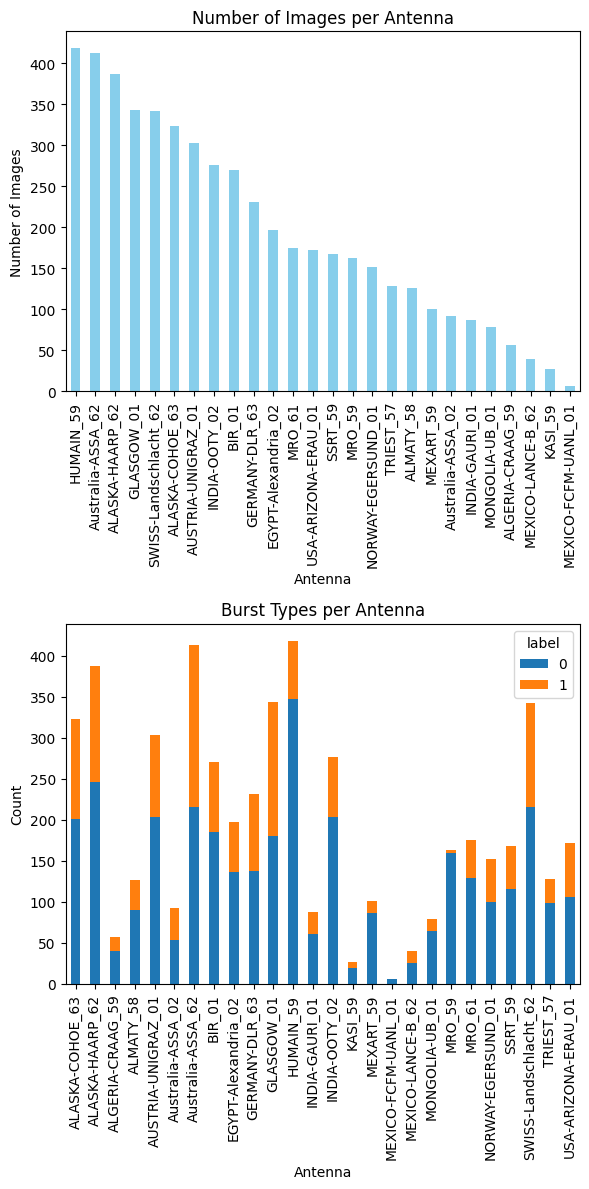

In [40]:
# EDA
import matplotlib.pyplot as plt
# Number of images per antenna
images_per_antenna = test_df['antenna'].value_counts()

# Number of burst types per antenna
burst_types_per_antenna = test_df.groupby('antenna')['label'].value_counts().unstack(fill_value=0)

# Date range per antenna
date_range_per_antenna = test_df.groupby('antenna')['datetime'].agg([min, max])

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# Images per antenna
images_per_antenna.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Number of Images per Antenna')
ax[0].set_xlabel('Antenna')
ax[0].set_ylabel('Number of Images')

# Burst types per antenna
burst_types_per_antenna.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Burst Types per Antenna')
ax[1].set_xlabel('Antenna')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [41]:
from datasets import load_dataset
train = load_dataset('csv', data_files='/home/vincenzo/FlareSense-v2/train_metadata.csv')
valid = load_dataset('csv', data_files='/home/vincenzo/FlareSense-v2/val_metadata.csv')
test = load_dataset('csv', data_files='/home/vincenzo/FlareSense-v2/test_metadata.csv')

In [42]:
from datasets import Image
train = train.cast_column("image", Image())
valid = valid.cast_column("image", Image())
test = test.cast_column("image", Image())

In [43]:
from datasets import DatasetDict
dd = DatasetDict({"train": train['train'],"validation": valid['train'], "test":test['train']})

In [44]:
dd

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename', 'antenna', 'datetime'],
        num_rows: 39073
    })
    validation: Dataset({
        features: ['image', 'label', 'filename', 'antenna', 'datetime'],
        num_rows: 4990
    })
    test: Dataset({
        features: ['image', 'label', 'filename', 'antenna', 'datetime'],
        num_rows: 5076
    })
})

In [45]:
dd.push_to_hub('i4ds/radio-sunburst-ecallisto-binary-cleaned-4', private=False)

Uploading the dataset shards: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/i4ds/radio-sunburst-ecallisto-binary-cleaned-4/commit/5ec507f6a9e59574325b95b04bfd9bd3f513e966', commit_message='Upload dataset', commit_description='', oid='5ec507f6a9e59574325b95b04bfd9bd3f513e966', pr_url=None, pr_revision=None, pr_num=None)

In [46]:
dd['test']['label'][-1]

0

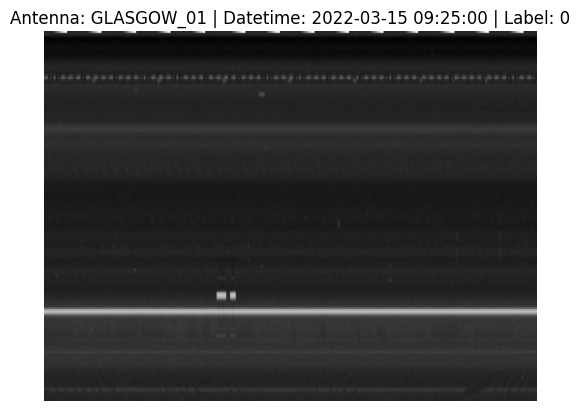

In [47]:
# Display the image
plt.imshow(dd['train'][35000]['image'], cmap='gray')  # 'gray' colormap for mode=L (grayscale)
plt.title(f"Antenna: {dd['train'][35000]['antenna']} | Datetime: {dd['train'][35000]['datetime']} | Label: {dd['train'][35000]['label']}")
plt.axis('off')  # Turn off the axis
plt.show()